<a href="https://colab.research.google.com/github/alcoleasnoelia/Proyecto1-IA-DigitalHouse-Grupo4/blob/master/2_Desafio_I_Redes_(title).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Continuación de la notebook anterior)
Notebook 3
    
6.  Modelado Avanzado Neural Networks (LSTMs)
    *   Red Secuencial Inicial
    *   Red Secuencial con regularizaciómn 
    *   Modelado de Red con Cross Validation
    *   Análisis final de performance
7.  Conclusiones



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import re

#Librerias para generación de features
import string
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
#Librerias para construcción de red
from keras import losses
from keras import metrics
from keras import optimizers
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Embedding
from keras import regularizers

Using TensorFlow backend.


In [0]:
def correr_stemming(text):
    # Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return(text)

Cargamos el dataset a partir del pickle generado por la notebook de limpieza:

In [0]:
news = pd.read_pickle("news_.p")

In [0]:
news.head(5)

,title,text,subject,date,text_st,fakenews_,title_clean,text_clean,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity,title_clean_polarity,title_clean_subjectivity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",washington (reuters) - the head of a conserv r...,0,us budget fight looms republicans flip fiscal ...,head conservative republican faction us congre...,0.037083,0.410250,0.00,0.0,0.036979,0.403438,0.0,0.00
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",washington (reuters) - transgend peopl will be...,0,us military accept transgender recruits monday...,transgender people allowed first time enlist u...,0.055880,0.298557,-0.10,0.1,0.113095,0.296168,-0.1,0.10
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",washington (reuters) - the special counsel inv...,0,senior us republican senator let mr mueller job,special counsel investigation links russia pre...,0.115930,0.316798,0.00,0.0,0.129766,0.311252,0.0,0.00
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",washington (reuters) - trump campaign advis ge...,0,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos tol...,0.035968,0.306569,0.00,0.0,0.030305,0.276323,0.0,0.00
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",seattle/washington (reuters) - presid donald t...,0,trump wants postal service charge much amazon ...,president donald trump called us postal servic...,0.030093,0.399891,0.35,0.3,0.042130,0.379259,0.2,0.15


Dividimos el dataset en train y test con shuffle y estratificación:

In [0]:
data_train, data_test = train_test_split(news,test_size=0.30,shuffle=True,random_state=10, stratify=news["fakenews_"])

data_train = data_train.copy()
data_test = data_test.copy() 
print("data train shape: {}".format(data_train.shape))
print("data test shape: {}".format(data_test.shape))

data train shape: (31428, 16)
data test shape: (13470, 16)


In [0]:
X_train=data_train["title_clean"].apply(correr_stemming)
X_test=data_test["title_clean"].apply(correr_stemming)
y_train=data_train["fakenews_"].copy()
y_test=data_test["fakenews_"].copy()

In [0]:
X_train_partial=X_train[8000:]
X_val=X_train[:8000]
y_val=y_train[:8000]
y_train_partial=y_train[8000:]

In [0]:
X_train_partial.shape, X_val.shape, X_test.shape

((23428,), (8000,), (13470,))

# **4.   Feature Extraction**

A partir de una vectorizacion por TFIDF obtenemos 10.000 features principales:

In [0]:
tfidf_vec= TfidfVectorizer(stop_words='english', max_df=0.8, min_df=0.02)

In [0]:
X_train_partial_vec=tfidf_vec.fit_transform(X_train_partial).copy()
X_val_vec=tfidf_vec.transform(X_val).copy()
X_test_vec=tfidf_vec.transform(X_test).copy()
X_train_partial_vec.shape, X_val_vec.shape, X_test_vec.shape, y_test.shape

((23428, 31), (8000, 31), (13470, 31), (13470,))

In [0]:
(X_train_partial_vec.shape[1],)

(31,)

# **6.   Modelado Avanzado Neural Networks (LSTMs)**

Definimos una función para la construcción del modelo de capas densas:

In [0]:
def build_model(input_shape, layers=[15,10,1], optimizer='rmsprop'):
    # Instanciamos la clase del modelo secuencial
    model = Sequential(name='Modelo de base')
    
    #Configuramos la primera capa para que tome las features, con regularizacion l1
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train_partial_vec.shape[1],), kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))

    for l in layers[1:-1]:
        model.add(Dense(units=l, activation='relu'))
        model.add(Dropout(0.5))

    # Agregamos la última capa 
    model.add(Dense(units=layers[-1], activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    # Retornamos el modelo compilado
    return model


Realizamos una busqueda por iteraciones para encontrar los mejores hiperparametros 

In [0]:
from keras import optimizers

In [0]:
# Definimos la "grilla" de parámetros que vamos a explorar
layers = [[512, 10, 1], [64, 32,10, 1]]
optimizers = [ optimizers.SGD(momentum=0.9, nesterov=True), optimizers.Adam(), optimizers.RMSprop()]

In [0]:
import itertools
combinaciones = list(itertools.product(layers, optimizers))
combinaciones

[([512, 10, 1], <keras.optimizers.SGD at 0x180021b5cc8>),
 ([512, 10, 1], <keras.optimizers.Adam at 0x180021b5b88>),
 ([512, 10, 1], <keras.optimizers.RMSprop at 0x180021b5c48>),
 ([64, 32, 10, 1], <keras.optimizers.SGD at 0x180021b5cc8>),
 ([64, 32, 10, 1], <keras.optimizers.Adam at 0x180021b5b88>),
 ([64, 32, 10, 1], <keras.optimizers.RMSprop at 0x180021b5c48>)]

In [0]:
# Definamos algunas variables
n_splits = 3
batch_size = 3000
epochs = 60
verbose = 1

Creamos una lista vacía para ir guardando los entrenamientos y luego ejecutamos la función de cross validation para la selección del modelo con mejor arquitectura y optimizadores según su accuracy:

In [0]:
global_history = []

In [0]:
# Importamos KFold para hacer cross-validation
from sklearn.model_selection import KFold

# Instanciamos el objeto KFold
kfold = KFold(n_splits=n_splits, shuffle=False)

# Recorremos las combinaciones y generamos distintos modelos a ensayar
for (layers, optimizer) in combinaciones:
    print('\n\nEnsayando modelo con estructura {} y optimizador {}'.format(layers, optimizer))
    
    # Construimos el modelo
    
    model = build_model(input_shape=X_train_partial_vec.shape, layers=layers, optimizer=optimizer)
    
    # Guardamos los pesos iniciales para usarlos en cada fold
    model.save_weights('initial_weights.h5')
    
    # Generamos los sets de train y val para ensayar el modelo
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_partial_vec)):
        
        # Reiniciamos los pesos del modelo
        model.load_weights('initial_weights.h5')
        
        print(X_train_partial_vec.shape, X_val_vec.shape, X_test_vec.shape, y_train_partial.shape, y_val.shape, y_test.shape)       
        
        
        # Lo entrenamos con el split de x_train e y_train correspondiente
        history = model.fit(x=X_train_partial_vec,
                            y=y_train_partial,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_vec, y_val),
                            verbose=verbose
                           )
        
        
        
        # Evaluamos en train y en val (estos mismos valores los podemos sacar de history)
        train_loss, train_acc = model.evaluate(X_train_partial_vec, y_train_partial)
        val_loss, val_acc = model.evaluate(X_val_vec, y_val)
        
        # Agregamos esta corrida a la historia global
        global_history.append({'fold':fold, 
                               'layers':layers,
                               'optimizer':optimizer,
                               'train_loss':train_loss,
                               'train_acc':train_acc,
                               'val_loss':val_loss,
                               'val_acc':val_acc,
                               'history':history
                              })



Ensayando modelo con estructura [512, 10, 1] y optimizador <keras.optimizers.SGD object at 0x00000180021B5CC8>
(23428, 31) (8000, 31) (13470, 31) (23428,) (8000,) (13470,)
Train on 23428 samples, validate on 8000 samples
Epoch 1/60
23428/23428 [==============================] - 1s 60us/step - loss: 1.5164 - binary_accuracy: 0.5321 - val_loss: 1.5113 - val_binary_accuracy: 0.5191
Epoch 2/60
23428/23428 [==============================] - 0s 11us/step - loss: 1.5072 - binary_accuracy: 0.5266 - val_loss: 1.4982 - val_binary_accuracy: 0.5191
Epoch 3/60
23428/23428 [==============================] - 0s 9us/step - loss: 1.4924 - binary_accuracy: 0.5307 - val_loss: 1.4823 - val_binary_accuracy: 0.5191
Epoch 4/60
23428/23428 [==============================] - 0s 10us/step - loss: 1.4771 - binary_accuracy: 0.5464 - val_loss: 1.4650 - val_binary_accuracy: 0.5191
Epoch 5/60
23428/23428 [==============================] - 0s 11us/step - loss: 1.4598 - binary_accuracy: 0.5659 - val_loss: 1.4469 - v

23428/23428 [==============================] - 0s 11us/step - loss: 0.8511 - binary_accuracy: 0.7547 - val_loss: 0.8161 - val_binary_accuracy: 0.7865
Epoch 51/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.8419 - binary_accuracy: 0.7535 - val_loss: 0.8078 - val_binary_accuracy: 0.7876
Epoch 52/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.8347 - binary_accuracy: 0.7532 - val_loss: 0.7995 - val_binary_accuracy: 0.7878
Epoch 53/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.8267 - binary_accuracy: 0.7536 - val_loss: 0.7911 - val_binary_accuracy: 0.7878
Epoch 54/60
23428/23428 [==============================] - 0s 8us/step - loss: 0.8168 - binary_accuracy: 0.7561 - val_loss: 0.7831 - val_binary_accuracy: 0.7878
Epoch 55/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.8115 - binary_accuracy: 0.7541 - val_loss: 0.7752 - val_binary_accuracy: 0.7883
Epoch 56/60
23428/23428 [=================

23428/23428 [==============================] - 0s 10us/step - loss: 0.9486 - binary_accuracy: 0.7494 - val_loss: 0.9140 - val_binary_accuracy: 0.7874
Epoch 40/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.9377 - binary_accuracy: 0.7494 - val_loss: 0.9034 - val_binary_accuracy: 0.7875
Epoch 41/60
23428/23428 [==============================] - ETA: 0s - loss: 0.9283 - binary_accuracy: 0.752 - 0s 9us/step - loss: 0.9268 - binary_accuracy: 0.7524 - val_loss: 0.8930 - val_binary_accuracy: 0.7876
Epoch 42/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.9174 - binary_accuracy: 0.7496 - val_loss: 0.8829 - val_binary_accuracy: 0.7875
Epoch 43/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.9070 - binary_accuracy: 0.7531 - val_loss: 0.8730 - val_binary_accuracy: 0.7875
Epoch 44/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.8972 - binary_accuracy: 0.7528 - val_loss: 0.8633 - val_binary_accuracy: 0

23428/23428 [==============================] - 0s 10us/step - loss: 1.0783 - binary_accuracy: 0.7400 - val_loss: 1.0479 - val_binary_accuracy: 0.7815
Epoch 29/60
23428/23428 [==============================] - 0s 10us/step - loss: 1.0654 - binary_accuracy: 0.7405 - val_loss: 1.0344 - val_binary_accuracy: 0.7826
Epoch 30/60
23428/23428 [==============================] - 0s 10us/step - loss: 1.0533 - binary_accuracy: 0.7430 - val_loss: 1.0210 - val_binary_accuracy: 0.7825
Epoch 31/60
23428/23428 [==============================] - 0s 9us/step - loss: 1.0416 - binary_accuracy: 0.7409 - val_loss: 1.0082 - val_binary_accuracy: 0.7857
Epoch 32/60
23428/23428 [==============================] - 0s 10us/step - loss: 1.0273 - binary_accuracy: 0.7431 - val_loss: 0.9956 - val_binary_accuracy: 0.7855
Epoch 33/60
23428/23428 [==============================] - 0s 9us/step - loss: 1.0148 - binary_accuracy: 0.7468 - val_loss: 0.9831 - val_binary_accuracy: 0.7855
Epoch 34/60
23428/23428 [=================

23428/23428 [==============================] - 0s 10us/step - loss: 0.5535 - binary_accuracy: 0.7436 - val_loss: 0.5180 - val_binary_accuracy: 0.7797
Epoch 17/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5469 - binary_accuracy: 0.7489 - val_loss: 0.5149 - val_binary_accuracy: 0.7806
Epoch 18/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5447 - binary_accuracy: 0.7460 - val_loss: 0.5122 - val_binary_accuracy: 0.7809
Epoch 19/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.5418 - binary_accuracy: 0.7512 - val_loss: 0.5090 - val_binary_accuracy: 0.7801
Epoch 20/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5424 - binary_accuracy: 0.7436 - val_loss: 0.5063 - val_binary_accuracy: 0.7799
Epoch 21/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5374 - binary_accuracy: 0.7506 - val_loss: 0.5043 - val_binary_accuracy: 0.7837
Epoch 22/60
23428/23428 [===============

23428/23428 [==============================] - 0s 10us/step - loss: 1.0867 - binary_accuracy: 0.7133 - val_loss: 0.9985 - val_binary_accuracy: 0.7720
Epoch 6/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.9795 - binary_accuracy: 0.7283 - val_loss: 0.8922 - val_binary_accuracy: 0.7800
Epoch 7/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.8863 - binary_accuracy: 0.7373 - val_loss: 0.8043 - val_binary_accuracy: 0.7839
Epoch 8/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.8061 - binary_accuracy: 0.7448 - val_loss: 0.7337 - val_binary_accuracy: 0.7836
Epoch 9/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.7456 - binary_accuracy: 0.7456 - val_loss: 0.6763 - val_binary_accuracy: 0.7871
Epoch 10/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.6893 - binary_accuracy: 0.7522 - val_loss: 0.6298 - val_binary_accuracy: 0.7797
Epoch 11/60
23428/23428 [======================

Epoch 56/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.4936 - binary_accuracy: 0.7647 - val_loss: 0.4602 - val_binary_accuracy: 0.7875
Epoch 57/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.4911 - binary_accuracy: 0.7651 - val_loss: 0.4586 - val_binary_accuracy: 0.7893
Epoch 58/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.4906 - binary_accuracy: 0.7652 - val_loss: 0.4591 - val_binary_accuracy: 0.7887
Epoch 59/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.4914 - binary_accuracy: 0.7635 - val_loss: 0.4579 - val_binary_accuracy: 0.7901
Epoch 60/60
8000/8000 [==============================] - 0s 47us/step
(23428, 31) (8000, 31) (13470, 31) (23428,) (8000,) (13470,)
Train on 23428 samples, validate on 8000 samples
Epoch 1/60
23428/23428 [==============================] - 0s 11us/step - loss: 1.5111 - binary_accuracy: 0.5102 - val_loss: 1.4728 - val_binary_accuracy: 0.5667
Epoch 2/60
23

23428/23428 [==============================] - 0s 10us/step - loss: 0.5014 - binary_accuracy: 0.7626 - val_loss: 0.4701 - val_binary_accuracy: 0.7885
Epoch 46/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.5008 - binary_accuracy: 0.7633 - val_loss: 0.4683 - val_binary_accuracy: 0.7896
Epoch 47/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5014 - binary_accuracy: 0.7619 - val_loss: 0.4684 - val_binary_accuracy: 0.7876
Epoch 48/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.4995 - binary_accuracy: 0.7628 - val_loss: 0.4682 - val_binary_accuracy: 0.7886
Epoch 49/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.4994 - binary_accuracy: 0.7622 - val_loss: 0.4665 - val_binary_accuracy: 0.7894
Epoch 50/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5016 - binary_accuracy: 0.7617 - val_loss: 0.4669 - val_binary_accuracy: 0.7886
Epoch 51/60
23428/23428 [=================

Epoch 34/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.5212 - binary_accuracy: 0.7585 - val_loss: 0.4890 - val_binary_accuracy: 0.7818
Epoch 35/60
23428/23428 [==============================] - 0s 8us/step - loss: 0.5188 - binary_accuracy: 0.7615 - val_loss: 0.4857 - val_binary_accuracy: 0.7887
Epoch 36/60
23428/23428 [==============================] - 0s 9us/step - loss: 0.5193 - binary_accuracy: 0.7593 - val_loss: 0.4869 - val_binary_accuracy: 0.7843
Epoch 37/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.5198 - binary_accuracy: 0.7605 - val_loss: 0.4836 - val_binary_accuracy: 0.7891
Epoch 38/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5170 - binary_accuracy: 0.7621 - val_loss: 0.4841 - val_binary_accuracy: 0.7855
Epoch 39/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5173 - binary_accuracy: 0.7607 - val_loss: 0.4849 - val_binary_accuracy: 0.7849
Epoch 40/60
23428/23428 [======

23428/23428 [==============================] - 0s 10us/step - loss: 0.5432 - binary_accuracy: 0.7513 - val_loss: 0.5058 - val_binary_accuracy: 0.7872
Epoch 24/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5382 - binary_accuracy: 0.7551 - val_loss: 0.5029 - val_binary_accuracy: 0.7821
Epoch 25/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.5363 - binary_accuracy: 0.7527 - val_loss: 0.5070 - val_binary_accuracy: 0.7794
Epoch 26/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5339 - binary_accuracy: 0.7558 - val_loss: 0.5003 - val_binary_accuracy: 0.7889
Epoch 27/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5332 - binary_accuracy: 0.7544 - val_loss: 0.4981 - val_binary_accuracy: 0.7870
Epoch 28/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5307 - binary_accuracy: 0.7579 - val_loss: 0.4962 - val_binary_accuracy: 0.7820
Epoch 29/60
23428/23428 [===============

23428/23428 [==============================] - 0s 10us/step - loss: 0.5974 - binary_accuracy: 0.7424 - val_loss: 0.5537 - val_binary_accuracy: 0.7769
Epoch 13/60
23428/23428 [==============================] - 0s 11us/step - loss: 0.5817 - binary_accuracy: 0.7411 - val_loss: 0.5464 - val_binary_accuracy: 0.7790
Epoch 14/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5728 - binary_accuracy: 0.7439 - val_loss: 0.5354 - val_binary_accuracy: 0.7772
Epoch 15/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5635 - binary_accuracy: 0.7467 - val_loss: 0.5323 - val_binary_accuracy: 0.7789
Epoch 16/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5640 - binary_accuracy: 0.7489 - val_loss: 0.5262 - val_binary_accuracy: 0.7810
Epoch 17/60
23428/23428 [==============================] - 0s 10us/step - loss: 0.5595 - binary_accuracy: 0.7488 - val_loss: 0.5229 - val_binary_accuracy: 0.7849
Epoch 18/60
23428/23428 [===============

Train on 23428 samples, validate on 8000 samples
Epoch 1/60
23428/23428 [==============================] - 1s 59us/step - loss: 0.9442 - binary_accuracy: 0.4962 - val_loss: 0.9440 - val_binary_accuracy: 0.5138
Epoch 2/60
23428/23428 [==============================] - 0s 6us/step - loss: 0.9421 - binary_accuracy: 0.4991 - val_loss: 0.9420 - val_binary_accuracy: 0.5179
Epoch 3/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.9402 - binary_accuracy: 0.5038 - val_loss: 0.9400 - val_binary_accuracy: 0.5191
Epoch 4/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.9382 - binary_accuracy: 0.5039 - val_loss: 0.9379 - val_binary_accuracy: 0.5189
Epoch 5/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.9351 - binary_accuracy: 0.5088 - val_loss: 0.9357 - val_binary_accuracy: 0.5191
Epoch 6/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.9334 - binary_accuracy: 0.5131 - val_loss: 0.9336 - val_binary_accurac

23428/23428 [==============================] - 0s 4us/step - loss: 0.7677 - binary_accuracy: 0.6946 - val_loss: 0.7153 - val_binary_accuracy: 0.7761
Epoch 52/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7599 - binary_accuracy: 0.6969 - val_loss: 0.7081 - val_binary_accuracy: 0.7772
Epoch 53/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7544 - binary_accuracy: 0.7005 - val_loss: 0.7014 - val_binary_accuracy: 0.7761
Epoch 54/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7500 - binary_accuracy: 0.7005 - val_loss: 0.6958 - val_binary_accuracy: 0.7794
Epoch 55/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.7456 - binary_accuracy: 0.7048 - val_loss: 0.6899 - val_binary_accuracy: 0.7797
Epoch 56/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7425 - binary_accuracy: 0.7062 - val_loss: 0.6843 - val_binary_accuracy: 0.7799
Epoch 57/60
23428/23428 [=====================

23428/23428 [==============================] - 0s 4us/step - loss: 0.8142 - binary_accuracy: 0.6588 - val_loss: 0.7778 - val_binary_accuracy: 0.7706
Epoch 41/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8074 - binary_accuracy: 0.6659 - val_loss: 0.7689 - val_binary_accuracy: 0.7710
Epoch 42/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8012 - binary_accuracy: 0.6640 - val_loss: 0.7598 - val_binary_accuracy: 0.7709
Epoch 43/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7942 - binary_accuracy: 0.6724 - val_loss: 0.7514 - val_binary_accuracy: 0.7706
Epoch 44/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7910 - binary_accuracy: 0.6740 - val_loss: 0.7439 - val_binary_accuracy: 0.7746
Epoch 45/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7832 - binary_accuracy: 0.6827 - val_loss: 0.7363 - val_binary_accuracy: 0.7750
Epoch 46/60
23428/23428 [=====================

23428/23428 [==============================] - 0s 4us/step - loss: 0.8701 - binary_accuracy: 0.6080 - val_loss: 0.8609 - val_binary_accuracy: 0.6940
Epoch 30/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8681 - binary_accuracy: 0.6064 - val_loss: 0.8558 - val_binary_accuracy: 0.7060
Epoch 31/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8626 - binary_accuracy: 0.6121 - val_loss: 0.8505 - val_binary_accuracy: 0.7182
Epoch 32/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8582 - binary_accuracy: 0.6170 - val_loss: 0.8446 - val_binary_accuracy: 0.7258
Epoch 33/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8551 - binary_accuracy: 0.6218 - val_loss: 0.8384 - val_binary_accuracy: 0.7396
Epoch 34/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.8496 - binary_accuracy: 0.6281 - val_loss: 0.8319 - val_binary_accuracy: 0.7405
Epoch 35/60
23428/23428 [=====================

Epoch 18/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4857 - binary_accuracy: 0.7720 - val_loss: 0.4533 - val_binary_accuracy: 0.7866
Epoch 19/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4890 - binary_accuracy: 0.7711 - val_loss: 0.4529 - val_binary_accuracy: 0.7914
Epoch 20/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4869 - binary_accuracy: 0.7705 - val_loss: 0.4517 - val_binary_accuracy: 0.7886
Epoch 21/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.4860 - binary_accuracy: 0.7706 - val_loss: 0.4516 - val_binary_accuracy: 0.7876
Epoch 22/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4843 - binary_accuracy: 0.7718 - val_loss: 0.4502 - val_binary_accuracy: 0.7899
Epoch 23/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4847 - binary_accuracy: 0.7715 - val_loss: 0.4501 - val_binary_accuracy: 0.7889
Epoch 24/60
23428/23428 [=========

23428/23428 [==============================] - 0s 4us/step - loss: 0.7633 - binary_accuracy: 0.7043 - val_loss: 0.6946 - val_binary_accuracy: 0.7616
Epoch 8/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7304 - binary_accuracy: 0.7188 - val_loss: 0.6593 - val_binary_accuracy: 0.7716
Epoch 9/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.7085 - binary_accuracy: 0.7308 - val_loss: 0.6381 - val_binary_accuracy: 0.7754
Epoch 10/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.6848 - binary_accuracy: 0.7418 - val_loss: 0.6227 - val_binary_accuracy: 0.7750
Epoch 11/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.6695 - binary_accuracy: 0.7430 - val_loss: 0.6098 - val_binary_accuracy: 0.7754
Epoch 12/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.6511 - binary_accuracy: 0.7517 - val_loss: 0.5980 - val_binary_accuracy: 0.7766
Epoch 13/60
23428/23428 [=======================

Epoch 58/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4960 - binary_accuracy: 0.7718 - val_loss: 0.4621 - val_binary_accuracy: 0.7903
Epoch 59/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.4998 - binary_accuracy: 0.7718 - val_loss: 0.4620 - val_binary_accuracy: 0.7925
Epoch 60/60
8000/8000 [==============================] - 0s 48us/step
(23428, 31) (8000, 31) (13470, 31) (23428,) (8000,) (13470,)
Train on 23428 samples, validate on 8000 samples
Epoch 1/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.9378 - binary_accuracy: 0.4947 - val_loss: 0.9271 - val_binary_accuracy: 0.5094
Epoch 2/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.9232 - binary_accuracy: 0.5169 - val_loss: 0.9129 - val_binary_accuracy: 0.5195
Epoch 3/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.9073 - binary_accuracy: 0.5300 - val_loss: 0.8931 - val_binary_accuracy: 0.5204
Epoch 4/60
23428/2

23428/23428 [==============================] - 0s 4us/step - loss: 0.5129 - binary_accuracy: 0.7697 - val_loss: 0.4735 - val_binary_accuracy: 0.7899
Epoch 48/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5071 - binary_accuracy: 0.7714 - val_loss: 0.4716 - val_binary_accuracy: 0.7885
Epoch 49/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5093 - binary_accuracy: 0.7683 - val_loss: 0.4700 - val_binary_accuracy: 0.7912
Epoch 50/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.5073 - binary_accuracy: 0.7707 - val_loss: 0.4694 - val_binary_accuracy: 0.7901
Epoch 51/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5066 - binary_accuracy: 0.7679 - val_loss: 0.4678 - val_binary_accuracy: 0.7903
Epoch 52/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4993 - binary_accuracy: 0.7712 - val_loss: 0.4659 - val_binary_accuracy: 0.7915
Epoch 53/60
23428/23428 [=====================

23428/23428 [==============================] - 0s 4us/step - loss: 0.4997 - binary_accuracy: 0.7692 - val_loss: 0.4612 - val_binary_accuracy: 0.7905
Epoch 36/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.4972 - binary_accuracy: 0.7673 - val_loss: 0.4605 - val_binary_accuracy: 0.7890
Epoch 37/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.5010 - binary_accuracy: 0.7673 - val_loss: 0.4599 - val_binary_accuracy: 0.7906
Epoch 38/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.5004 - binary_accuracy: 0.7703 - val_loss: 0.4594 - val_binary_accuracy: 0.7894
Epoch 39/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.4994 - binary_accuracy: 0.7667 - val_loss: 0.4574 - val_binary_accuracy: 0.7881
Epoch 40/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.4976 - binary_accuracy: 0.7690 - val_loss: 0.4574 - val_binary_accuracy: 0.7906
Epoch 41/60
23428/23428 [=====================

23428/23428 [==============================] - 0s 4us/step - loss: 0.5494 - binary_accuracy: 0.7592 - val_loss: 0.4952 - val_binary_accuracy: 0.7876
Epoch 25/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.5476 - binary_accuracy: 0.7573 - val_loss: 0.4918 - val_binary_accuracy: 0.7868
Epoch 26/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5395 - binary_accuracy: 0.7614 - val_loss: 0.4874 - val_binary_accuracy: 0.7883
Epoch 27/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5314 - binary_accuracy: 0.7620 - val_loss: 0.4822 - val_binary_accuracy: 0.7880
Epoch 28/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5259 - binary_accuracy: 0.7632 - val_loss: 0.4785 - val_binary_accuracy: 0.7894
Epoch 29/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.5233 - binary_accuracy: 0.7628 - val_loss: 0.4755 - val_binary_accuracy: 0.7879
Epoch 30/60
23428/23428 [=====================

23428/23428 [==============================] - 0s 4us/step - loss: 0.6727 - binary_accuracy: 0.7206 - val_loss: 0.6039 - val_binary_accuracy: 0.7815
Epoch 14/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.6539 - binary_accuracy: 0.7289 - val_loss: 0.5868 - val_binary_accuracy: 0.7804
Epoch 15/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.6424 - binary_accuracy: 0.7327 - val_loss: 0.5736 - val_binary_accuracy: 0.7797
Epoch 16/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.6314 - binary_accuracy: 0.7394 - val_loss: 0.5600 - val_binary_accuracy: 0.7831
Epoch 17/60
23428/23428 [==============================] - 0s 5us/step - loss: 0.6149 - binary_accuracy: 0.7432 - val_loss: 0.5487 - val_binary_accuracy: 0.7859
Epoch 18/60
23428/23428 [==============================] - 0s 4us/step - loss: 0.6035 - binary_accuracy: 0.7474 - val_loss: 0.5396 - val_binary_accuracy: 0.7854
Epoch 19/60
23428/23428 [=====================

Generamos un dataframe con las métricas por fold para luego seleccionar los mejores resultados:

In [0]:
import pandas as pd
df = pd.DataFrame(global_history)
df.head()

,fold,layers,optimizer,train_loss,train_acc,val_loss,val_acc,history
0,0,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.743590,0.777958,0.736991,0.788125,<keras.callbacks.callbacks.History object at 0...
1,1,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.736232,0.776976,0.729643,0.786625,<keras.callbacks.callbacks.History object at 0...
2,2,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.736522,0.778043,0.729899,0.788375,<keras.callbacks.callbacks.History object at 0...
3,0,"[512, 10, 1]",<keras.optimizers.Adam object at 0x00000180021...,0.471405,0.779793,0.463725,0.790375,<keras.callbacks.callbacks.History object at 0...
4,1,"[512, 10, 1]",<keras.optimizers.Adam object at 0x00000180021...,0.465682,0.779537,0.457773,0.789500,<keras.callbacks.callbacks.History object at 0...


In [0]:
df.head(19)

,fold,layers,optimizer,train_loss,train_acc,val_loss,val_acc,history
0,0,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.743590,0.777958,0.736991,0.788125,<keras.callbacks.callbacks.History object at 0...
1,1,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.736232,0.776976,0.729643,0.786625,<keras.callbacks.callbacks.History object at 0...
2,2,"[512, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.736522,0.778043,0.729899,0.788375,<keras.callbacks.callbacks.History object at 0...
3,0,"[512, 10, 1]",<keras.optimizers.Adam object at 0x00000180021...,0.471405,0.779793,0.463725,0.790375,<keras.callbacks.callbacks.History object at 0...
4,1,"[512, 10, 1]",<keras.optimizers.Adam object at 0x00000180021...,0.465682,0.779537,0.457773,0.789500,<keras.callbacks.callbacks.History object at 0...
5,2,"[512, 10, 1]",<keras.optimizers.Adam object at 0x00000180021...,0.468963,0.778982,0.461303,0.788250,<keras.callbacks.callbacks.History object at 0...
6,0,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x00000180...,0.476183,0.778641,0.468621,0.787500,<keras.callbacks.callbacks.History object at 0...
7,1,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x00000180...,0.477406,0.778812,0.469716,0.787250,<keras.callbacks.callbacks.History object at 0...
8,2,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x00000180...,0.476675,0.778684,0.468830,0.790125,<keras.callbacks.callbacks.History object at 0...
9,0,"[64, 32, 10, 1]",<keras.optimizers.SGD object at 0x00000180021B...,0.669320,0.771086,0.664577,0.779750,<keras.callbacks.callbacks.History object at 0...


Verificamos que el maximo accuracy en validacion se obtuvo en el indice 13, con optimizador Adam, y estructura de layers [64, 32, 10, 1].

In [0]:
best_iteration = df.iloc[np.argmax(df['val_acc'])]

C:\Users\maxir\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [0]:
best_iteration

fold                                                          1
layers                                          [64, 32, 10, 1]
optimizer     <keras.optimizers.Adam object at 0x00000180021...
train_loss                                             0.468873
train_acc                                              0.782098
val_loss                                               0.461023
val_acc                                                   0.792
history       <keras.callbacks.callbacks.History object at 0...
Name: 13, dtype: object

In [0]:
layers = best_iteration[1]
optimizer = best_iteration[2]

Construimos nuevamente el modelo a fines de plotear los scores en cada epoch:

In [0]:
def build_model(input_shape, layers=layers, optimizer=optimizer):
    # Instanciamos la clase del modelo secuencial
    model = Sequential(name='Modelo de base')
    
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train_partial_vec.shape[1],), kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))

    for l in layers[1:-1]:
        model.add(Dense(units=l, activation='relu'))
        model.add(Dropout(0.5))

    # Agregamos la última capa 
    model.add(Dense(units=layers[-1], activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    # Retornamos el modelo compilado
    return model

En base a los parametros seleccionados, la arquitectura del modelo es la siguiente:

In [0]:
model.summary()

Model: "Modelo de base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                2048      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)              

In [0]:
model.load_weights('initial_weights.h5')
history=model.fit(x=X_train_partial_vec,
                  y=y_train_partial,
                  batch_size=batch_size,
                  epochs=epochs, 
                  validation_split=0.3,
                  verbose=1)

Train on 16399 samples, validate on 7029 samples
Epoch 1/60
16399/16399 [==============================] - 0s 7us/step - loss: 0.9330 - binary_accuracy: 0.5116 - val_loss: 0.9211 - val_binary_accuracy: 0.6137
Epoch 2/60
16399/16399 [==============================] - 0s 6us/step - loss: 0.9197 - binary_accuracy: 0.5175 - val_loss: 0.9060 - val_binary_accuracy: 0.6090
Epoch 3/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.9079 - binary_accuracy: 0.5285 - val_loss: 0.8908 - val_binary_accuracy: 0.6031
Epoch 4/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.8934 - binary_accuracy: 0.5558 - val_loss: 0.8740 - val_binary_accuracy: 0.6907
Epoch 5/60
16399/16399 [==============================] - 0s 4us/step - loss: 0.8782 - binary_accuracy: 0.5894 - val_loss: 0.8554 - val_binary_accuracy: 0.7038
Epoch 6/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.8624 - binary_accuracy: 0.6110 - val_loss: 0.8355 - val_binary_accuracy

16399/16399 [==============================] - 0s 5us/step - loss: 0.5005 - binary_accuracy: 0.7691 - val_loss: 0.4711 - val_binary_accuracy: 0.7766
Epoch 52/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.5013 - binary_accuracy: 0.7696 - val_loss: 0.4706 - val_binary_accuracy: 0.7771
Epoch 53/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.5031 - binary_accuracy: 0.7668 - val_loss: 0.4707 - val_binary_accuracy: 0.7771
Epoch 54/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.5017 - binary_accuracy: 0.7679 - val_loss: 0.4693 - val_binary_accuracy: 0.7771
Epoch 55/60
16399/16399 [==============================] - 0s 5us/step - loss: 0.4975 - binary_accuracy: 0.7668 - val_loss: 0.4685 - val_binary_accuracy: 0.7771
Epoch 56/60
16399/16399 [==============================] - 0s 4us/step - loss: 0.4999 - binary_accuracy: 0.7694 - val_loss: 0.4673 - val_binary_accuracy: 0.7785
Epoch 57/60
16399/16399 [=====================

In [0]:
def plot_history(name, history, legend, plot_val=True):
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle(name)
    
    if not isinstance(history, list):
        history = [history]
        
    for h in history:
        acc = h.history['binary_accuracy']
        loss = h.history['loss']
        if plot_val:
            val_loss = h.history['val_loss']
            val_acc = h.history['val_binary_accuracy']
        epochs = range(1, len(acc) + 1)

        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        lb, ub = ax[0].get_xlim( )
        ax[0].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[0].set_ylim([0, 1])
        ax[0].set_yticks( np.linspace(0, 1, 6 ) )
        ax[0].set_ylabel('Loss')
        
        ax[0].plot(epochs, loss)
        if plot_val:
            ax[0].plot(epochs, val_loss)
            
        ax[1].set_title('Accuracy')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        lb, ub = ax[1].get_xlim( )
        ax[1].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks( np.linspace(0, 1, 6 ) )
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(epochs, acc)
        
        if plot_val:
            ax[1].plot(epochs, val_acc)
        
    ax[0].legend([l+' loss' for l in legend])
    ax[1].legend([l+' accuracy' for l in legend])

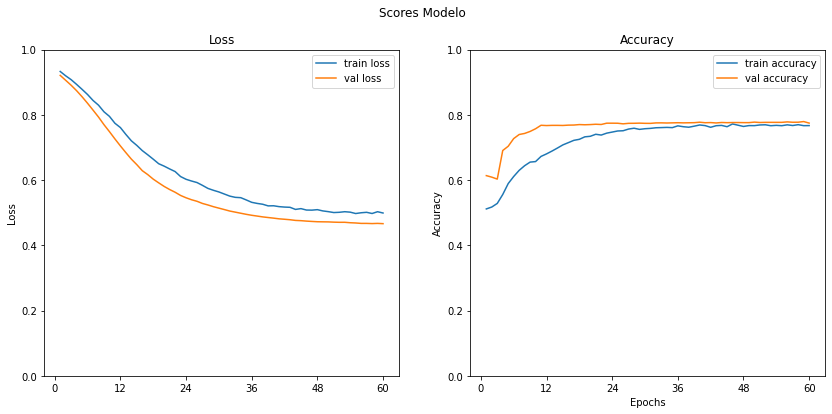

In [0]:
plot_history('Scores Modelo', history, ['train', 'val'])
plt.savefig('Scores Red.jpg', dpi=300)

En base a las predicciones ploteamos el accuracy obtenido:

In [0]:
from sklearn.metrics import accuracy_score
y_pred =model.predict_classes(X_test_vec)

print("Accuracy sobre Red: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy sobre Red: 0.7780994803266518


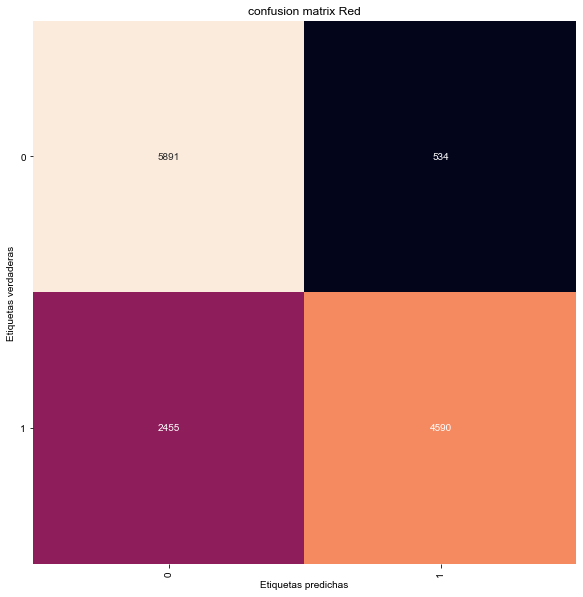

In [0]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10, 10))
classes = unique_labels(y_test, y_pred)
plt.title("confusion matrix Red")

mat = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
sns.set(font_scale=2) 

plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);

plt.savefig('Matriz Confusion Red.jpg', dpi=300)